First we start with importing the libraries

In [0]:
import pandas as pd
import shutil
import re
import nltk
import matplotlib as plt

In [19]:
nltk.download("punkt")
nltk.download("perluniprops")

from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

from nltk.tokenize.moses import MosesDetokenizer
detokenizer = MosesDetokenizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!


Now we fetch our tokens data

In [20]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
filename = "All_Entries (1).json"
shutil.copy2('/content/gdrive/My Drive/'+filename,'.')

All_Entries = pd.read_json(filename).reset_index(drop=True)
All_Entries.begin = All_Entries.begin.astype(int)
All_Entries.end = All_Entries.end.astype(int)
All_Entries.delete = All_Entries.delete.astype(bool)
All_Entries.substr_words = All_Entries.substr_words.astype(int)

In [23]:
import tensorflow as tf
import tensorflow_hub as hub

W0429 16:27:05.147271 140290639460224 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [25]:
!pip install bert-tensorflow

    100% |████████████████████████████████| 71kB 2.7MB/s 


In [0]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [27]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

class NonMaskOmittingTokenizer(bert.tokenization.FullTokenizer):
  def tokenize(self, text):
    split_tokens = []
    for token in self.basic_tokenizer.tokenize(text):
      for sub_token in self.wordpiece_tokenizer.tokenize(token):
        split_tokens.append(sub_token)

    for index, item in enumerate(split_tokens):
      if index >= len(split_tokens)-2:
        break
      if item == '[' and split_tokens[index + 1] == 'mask' and split_tokens[index + 2] == ']':
        split_tokens[index] = "[MASK]"
        del split_tokens[index + 1]
        del split_tokens[index + 1]

    return split_tokens

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return NonMaskOmittingTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

Instructions for updating:
Colocations handled automatically by placer.


W0429 16:27:40.289566 140290639460224 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0429 16:27:42.683504 140290639460224 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [28]:
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

In [0]:
All_Entries['context_tokens'] = 0
All_Entries['context_tokens'] = All_Entries['context'].apply(lambda x: len(tokenizer.tokenize(x)))

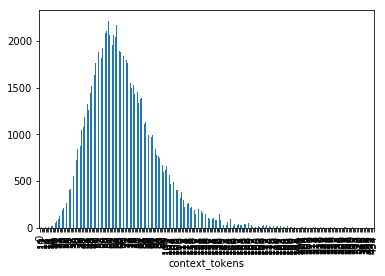

In [30]:
%matplotlib inline

data = All_Entries.groupby('context_tokens').size()
data.plot(kind='bar')

In [0]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  tot = pd.DataFrame(data)
  display(tot)

In [0]:
tot['percentile'] = 0

s = 0
Sum = sum(data)

for i, row in tot.iterrows():
  s += row[0]
  tot.at[i,'percentile'] = round(float((s*100)/Sum), 2)

In [63]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(tot)

,0,percentile
context_tokens,,
0,150,0
10,9,0
11,3,0
12,2,0
13,9,0
14,9,0
15,13,0
16,14,0
17,22,0


This tells us that setting the `MAX_TOKENS_LIMIT` to 128 should leave around 97% of contexts uncut, so it's an acceptable boundary.

# Adding contexts

Let's get our data here

In [0]:
import shutil

drive_path = "Clean REALEC dumps/" #@param {type:"string"}
filename = "realec_110319_2315.tar.gz" #@param {type:"string"}


shutil.copy2('/content/gdrive/My Drive/'+drive_path+filename,'.')

'./realec_110319_2315.tar.gz'

In [0]:
import tarfile

tar = tarfile.open(filename)
tar.extractall()

Time to create another monster: a structure to contain all the texts we're interested in

In [0]:
%%time

Texts = list(set([x[:-4]+'.txt' for x in list(All_Entries["path"])]))
Text_Dict = {path: open(path, 'r', encoding='utf-8-sig').read() for path in Texts}

CPU times: user 176 ms, sys: 90.3 ms, total: 266 ms
Wall time: 264 ms


In [0]:
print(len(Text_Dict))

5554


Now let's add unmasked entries to our dataset

In [0]:
All_Entries['unmasked_context'] = ""

We still shoulda check a pair of things...

In [0]:
raw = chr(8)
raw = re.sub(r'\s', ' ', raw)
raw = re.sub(r'( )+', ' ', raw)
raw

'\x08'

In [0]:
s = "This is a generic example. This is "+chr(8)+" example of masked context."
ss = nltk.sent_tokenize(s)
ss

['This is a generic example.', 'This is \x08 example of masked context.']

Working great! Good to go.

In [0]:
%%time

for i, row in All_Entries.iterrows():
  fpath = row['path'][:-4]+'.txt'
  start = row['begin']
  end = row['end']
  raw = Text_Dict[fpath]
  substr = raw[start:end]
  raw = raw[:start] + chr(8) + raw[end:]
  raw = re.sub(r'\s', ' ', raw)
  raw = re.sub(r'( )+', ' ', raw)
  sentences = nltk.sent_tokenize(raw)
  for k in range(len(sentences)):
    if chr(8) in sentences[k]:
      if k < 2:
        retstr = ' '.join(sentences[0:k+3])
        retstr = retstr.replace(chr(8), substr)
        All_Entries.at[i,'unmasked_context'] = retstr
      else:
        retstr = ' '.join(sentences[k-2:k+3])
        retstr = retstr.replace(chr(8), substr)
        All_Entries.at[i,'unmasked_context'] = retstr
      break

CPU times: user 1min 49s, sys: 217 ms, total: 1min 49s
Wall time: 1min 49s


In [0]:
list(All_Entries.sample(5)["unmasked_context"])

['The chart illustrates a variety levels of post-school in Australia and shows the ammount of men and women who held them in 1999. On the chart one can see that more males than femals held skilled vocational diploma. Only about 10% females had it while about 90% of males prefered to held it in 1999. By compromising, the undergraduate diploma had about 70% of females and only 35% of males kept it.',
 'There are laws about private rights of property in many countries. Pirats are not always punished or pursued and moreover people downloading these files should get punishment too. It can be agreed with the statement about getting punishment both for hackers and people using pirat’s copies. First of all, using materials of theft is the same support as making theft comes true. So, people should be punished for these acts as helpers for crimes.',
 'In the contrary, in 2000 in South Asia there was a great number of uneducated children, but this one decreased significantly and reached the botto

# Uploading the results

Wow. That was epic and took a looong time. We'd better save it into a json file to accelerate future load-ups.

In [0]:
%%time

jsonname = "All_Entries.json" #@param {type:"string"}
with open(jsonname, 'w', encoding="utf-8") as outie:
    exec("outie.write("+jsonname[:-5]+".to_json())")

CPU times: user 536 ms, sys: 434 ms, total: 970 ms
Wall time: 971 ms


Whew, great! Let's upload this to Google Drive right now. 

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': jsonname})
uploaded.SetContentFile(jsonname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1GnQL9_ePBj4GIXThG6ZwBTIhFMo_FHR2
